In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


import torch
import torchtext
from torchtext import data
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#os.chdir("/content/drive/MyDrive/ECE1786/Project")
%cd /content/drive/MyDrive/Colab Notebooks/ECE1786/Project

/content/drive/MyDrive/Colab Notebooks/ECE1786/Project


In [4]:
ls

baselines.ipynb  BERT_GRU.ipynb  data/                     GPT2.ipynb
BERT_base.ipynb  CNN.ipynb       data_preprocessing.ipynb


# Prepare the Data for Input
we will use TorchText with our edited Dataset to prepare the model input data

In [5]:
train = pd.read_csv('data/train.tsv', sep="\t")[['tweet', 'class']]
val = pd.read_csv('data/validation.tsv', sep="\t")[['tweet', 'class']]
test = pd.read_csv('data/test.tsv', sep="\t")[['tweet', 'class']]

In [6]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, split="train"):
        data_path = "data"
        df = pd.read_csv(os.path.join(data_path, f"{split}.tsv"), sep="\t")

        # X: torch.tensor (maxlen, batch_size), padded indices
        # Y: torch.tensor of len N
        X, Y = [], []
        V = len(vocab.vectors)
        for i, row in df.iterrows():
            L = row["tweet"].split()
            X.append(torch.tensor([vocab.stoi.get(w, V-1) for w in L]))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row["class"])
        self.X = X 
        self.Y = torch.tensor(Y)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx] 
    
# my_collate_function prepares batches
# it also pads each batch with zeroes.

def my_collate_function(batch, device):
    # Handle the padding here
    # batch is approximately: [dataset[i] for i in range(0, batch_size)]
    # Since the dataset[i]'s contents is defined in the __getitem__() above, this collate function 
    # should be set correspondingly.
    # Also: collate_function just takes one argument. To pass in additional arguments (e.g., device), 
    # we need to wrap up an anonymous function (using lambda below)
    batch_x, batch_y = [], []
    max_len = 0
    for x,y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x,y in batch:
        x_p = torch.concat(
            [x, torch.zeros(max_len - len(x))]
        )
        batch_x.append(x_p)
    return torch.stack(batch_x).t().int().to(device), torch.tensor(batch_y).to(device)

In [7]:
batch_size_num = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
glove = torchtext.vocab.GloVe(name="6B",dim=100) # embedding size = 100
                                
train_dataset = TextDataset(glove, "train")
val_dataset = TextDataset(glove, "validation")
test_dataset = TextDataset(glove, "test")
    
train_dataloader = torch.utils.data.DataLoader(
  dataset=train_dataset, 
  batch_size=batch_size_num, 
  shuffle=False, 
  collate_fn=lambda batch: my_collate_function(batch, device))

validation_dataloader = torch.utils.data.DataLoader(
  dataset=val_dataset, 
  batch_size=batch_size_num, 
  shuffle=False, 
  collate_fn=lambda batch: my_collate_function(batch, device))

test_dataloader = torch.utils.data.DataLoader(
  dataset=test_dataset,
  batch_size=len(test_dataset),
  shuffle=False,
  collate_fn=lambda batch: my_collate_function(batch, device))

# for text, label in train_dataloader:
#   print(text)
#   print(label)

# Define the models & training

## ConvolutionalNeural Network + Words Embeddings Model


In [8]:
class CNNModel(torch.nn.Module):
    def __init__(self, vocab, k1=3, n1=25, k2=5, n2=25, freeze=True):
        super().__init__()
        self.n1 = n1
        self.n2 = n2
        self.embedding = torch.nn.Embedding.from_pretrained(vocab.vectors,freeze=freeze)
        self.embedding_size = vocab.vectors.size()[1]
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=n1, kernel_size=(k1, self.embedding_size), bias=True)
        self.conv2 = torch.nn.Conv2d(in_channels=1, out_channels=n2, kernel_size=(k2, self.embedding_size), bias=True)
        self.linear = torch.nn.Linear(n1 + n2, 3)
        
    def forward(self, x):


        x_embed  = self.embedding(x)
        x_reshaped = x_embed.permute(1, 0, 2).unsqueeze(1)

        pool = torch.nn.MaxPool2d(1, x_embed.shape[0] - 1)
        activation = torch.nn.Sigmoid()

        x_conv1 = F.relu(self.conv1(x_reshaped)).squeeze(3)
        x_conv2 = F.relu(self.conv2(x_reshaped)).squeeze(3)

        x1 = F.max_pool1d(x_conv1, kernel_size=x_conv1.shape[2])
        x2 = F.max_pool1d(x_conv2, kernel_size=x_conv2.shape[2])
        x_cat = torch.cat((x1, x2), 1).squeeze()
        x_linear = x_cat.view(-1, self.n1 + self.n2)
        output = self.linear(x_cat)
        output_softmax = torch.softmax(output, 0)

        return output_softmax


In [9]:
def train_model(glove, train_dataloader, validation_dataloader, learning_rate, epochs, batch_size, k1=3, n1=25, k2=5, n2=25, freeze=True):

    # Instantiate the model & set up the optimizer
    # model = BaselineModel(embedding_size, glove)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print ("Using device:", device)

    model = CNNModel(glove, k1=k1, n1=n1, k2=k2, n2=n2, freeze=freeze)
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss() # Cross Entropy [0.2 0.7 0.1] [0, 1, 0]
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, val_losses, train_acc, val_acc = [], [], [], []

    for epoch in range(epochs):
        train_loss, val_loss, train_acc_count_epoch, val_acc_count_epoch = 0, 0, 0, 0

        for text, label in train_dataloader:
            # forward
            output = model(text) 
            loss = criterion(output.squeeze(), label.squeeze())
            # output = torch.softmax(output, 1)
            output = torch.max(output, 1).indices
            train_acc_count_epoch += torch.sum(output == label).item()
            
            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        mean_train_loss = train_loss / len(train_dataloader)
        mean_train_acc = train_acc_count_epoch / (len(train_dataloader) * batch_size)

        with torch.no_grad():
            for text_val, label_val in validation_dataloader:
                output_val = model(text_val) 
                loss_val = criterion(output_val.squeeze(), label_val.squeeze())
                val_loss += loss_val.item()

                output_val = torch.max(output_val, 1).indices
                val_acc_count_epoch += torch.sum(output_val == label_val).item()

        mean_val_loss = val_loss / len(validation_dataloader)
        mean_val_acc = val_acc_count_epoch / (len(validation_dataloader) * batch_size)


        if epoch==0 or (epoch+1) % 10 == 0 or epoch == epochs-1:
            print(' Epoch {} \ttraining loss={:.7f} \tvalidation loss={:.7f}'.format(epoch+1,mean_train_loss,mean_val_loss))
            print('     \t\ttraining accuracy={:.2f}% \tvalidation accuracy={:.2f}%'.format(mean_train_acc*100, mean_val_acc*100))

        train_losses.append(mean_train_loss)
        val_losses.append(mean_val_loss)
        train_acc.append(mean_train_acc)
        val_acc.append(mean_val_acc)


    return model, train_losses, val_losses, train_acc, val_acc
  

In [10]:

for k1,k2 in [[3,5],[4,5],[3,6],[4,6]]:
    for n in range(25,46,10):
        print("*"*25,"k1, k2, n =",k1,k2,n,"*"*25)
        model, train_losses, val_losses, train_acc, val_acc = train_model(glove, train_dataloader, validation_dataloader, 1e-4, 50, batch_size_num
                                                                        , k1=k1, n1=n, k2=k2, n2=n, freeze=True)

************************* k1, k2, n = 3 5 25 *************************
Using device: cuda
 Epoch 1 	training loss=1.0557557 	validation loss=1.0138161
     		training accuracy=66.94% 	validation accuracy=76.67%
 Epoch 10 	training loss=0.9884492 	validation loss=0.9925590
     		training accuracy=85.82% 	validation accuracy=85.19%
 Epoch 20 	training loss=0.9851116 	validation loss=0.9914468
     		training accuracy=87.01% 	validation accuracy=85.96%
 Epoch 30 	training loss=0.9836368 	validation loss=0.9909600
     		training accuracy=87.55% 	validation accuracy=86.33%
 Epoch 40 	training loss=0.9827685 	validation loss=0.9908487
     		training accuracy=87.99% 	validation accuracy=86.69%
 Epoch 50 	training loss=0.9822370 	validation loss=0.9909637
     		training accuracy=88.15% 	validation accuracy=86.85%
************************* k1, k2, n = 3 5 35 *************************
Using device: cuda
 Epoch 1 	training loss=1.0504897 	validation loss=1.0094102
     		training accuracy=68.

In [11]:
epochs = 150
learning_rate = 3e-5
torch.manual_seed(2) # fix seed


model, train_losses, val_losses, train_acc, val_acc = train_model(glove, train_dataloader, validation_dataloader, learning_rate, epochs, batch_size_num
                                                                  , k1=3, n1=45, k2=5, n2=45, freeze=True)


Using device: cuda
 Epoch 1 	training loss=1.0856354 	validation loss=1.0666379
     		training accuracy=60.11% 	validation accuracy=68.58%
 Epoch 10 	training loss=0.9930506 	validation loss=0.9945173
     		training accuracy=84.51% 	validation accuracy=83.92%
 Epoch 20 	training loss=0.9885848 	validation loss=0.9924298
     		training accuracy=86.46% 	validation accuracy=85.67%
 Epoch 30 	training loss=0.9865147 	validation loss=0.9915894
     		training accuracy=87.38% 	validation accuracy=86.17%
 Epoch 40 	training loss=0.9852273 	validation loss=0.9911472
     		training accuracy=87.79% 	validation accuracy=86.69%
 Epoch 50 	training loss=0.9843405 	validation loss=0.9908561
     		training accuracy=88.05% 	validation accuracy=86.94%
 Epoch 60 	training loss=0.9836668 	validation loss=0.9905700
     		training accuracy=88.28% 	validation accuracy=87.35%
 Epoch 70 	training loss=0.9831274 	validation loss=0.9903573
     		training accuracy=88.48% 	validation accuracy=87.38%
 Epoch

In [16]:
torch.save(model.state_dict(), 'CNN.pt')

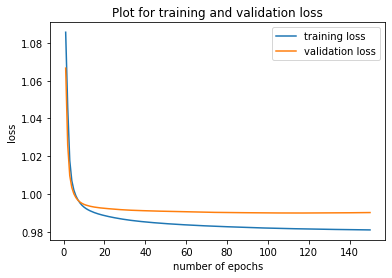

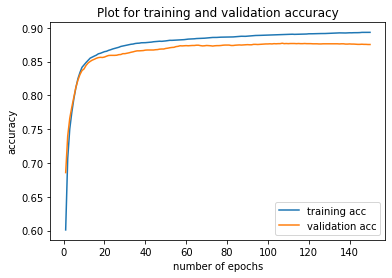

In [12]:
fig = plt.figure()
plt.plot(range(1, epochs+1), train_losses, label ='training loss')
plt.plot(range(1, epochs+1), val_losses, label ='validation loss')
plt.title("Plot for training and validation loss")
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(range(1, epochs+1), train_acc, label ='training acc')
plt.plot(range(1, epochs+1), val_acc, label ='validation acc')
plt.title("Plot for training and validation accuracy")
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [17]:
model.load_state_dict(torch.load('CNN.pt'))

<All keys matched successfully>

In [20]:
for text_test, label_test in test_dataloader:
    output_test = model(text_test) 
    output_test_softmax = torch.softmax(output_test, 1)
    label_pred = torch.max(output_test_softmax, 1).indices



In [22]:
print(classification_report(label_test.cpu(),label_pred.cpu()))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      2000
           1       0.93      0.83      0.88      2000
           2       0.88      0.94      0.91      2000

    accuracy                           0.89      6000
   macro avg       0.89      0.89      0.89      6000
weighted avg       0.89      0.89      0.89      6000



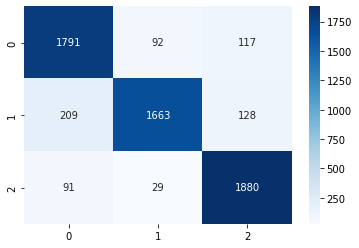

In [21]:
sns.heatmap(confusion_matrix(label_test.cpu(),label_pred.cpu()), annot=True, fmt='.0f', cmap=plt.cm.Blues)
plt.show()